In [1]:
import numpy as np
import matplotlib.pyplot as plt

Dataset path

In [2]:
data_set_path='/content/drive/MyDrive/Datasets/covid, normal, neumonia'

In [3]:
train_data_path='/content/drive/MyDrive/Datasets/covid, normal, neumonia/train/train'
test_data_path='/content/drive/MyDrive/Datasets/covid, normal, neumonia/test/test'

Making Images into linear format using tensorflow ImageDataGenerator

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image  import ImageDataGenerator 

In [5]:
preprocess_train=ImageDataGenerator(rescale=1. /255,
                                 shear_range=0.2,
                                 zoom_range=0.4,
                                 vertical_flip=True,
                                 horizontal_flip=True)

preprocess_test=ImageDataGenerator(rescale=1./255)

Collecting each image from train and test folder

In [6]:
labels=['COVID19','NORMAL','PNEUMONIA']

In [7]:
train_data=preprocess_train.flow_from_directory(train_data_path,
                                                target_size=[256,256],
                                                class_mode='categorical',
                                                classes=labels,
                                                batch_size=32)
test_data=preprocess_test.flow_from_directory(test_data_path,
                                              target_size=[256,256],
                                              class_mode='categorical',
                                              classes=labels,
                                              batch_size=32)

Found 5159 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


Now i am taking copy of VGG16 Architecture

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

Making Image Size

In [9]:
Image_size=[256,256]

In [10]:
sol=VGG16(input_shape=Image_size + [3] , weights='imagenet' , include_top = False)

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
#to make not to update weights of VGG16

for i in sol.layers:
  i.trainable = False

In [12]:
# developing my own output layer

from tensorflow.keras.layers import Flatten

In [13]:
y=Flatten()(sol.output)

In [14]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import softmax

In [15]:
from keras.api._v2.keras import activations
final = Dense(3, activation = 'softmax')(y)

In [16]:
from tensorflow.keras.models import Model

In [17]:
vgg16_model = Model(sol.inputs, final)

In [18]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [19]:
vgg16_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['Accuracy'])

In [20]:
vgg16_model.fit(train_data , epochs = 2)

Epoch 1/2
162/162 [==============================] - 2844s 17s/step - loss: 0.4244 - Accuracy: 0.8564
Epoch 2/2
162/162 [==============================] - 2766s 17s/step - loss: 0.2357 - Accuracy: 0.9099


Checking with test_data

In [22]:
test_data.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [23]:
y_test_pred=vgg16_model.predict(test_data)

41/41 [==============================] - 690s 17s/step


In [24]:
y_test_pred

array([[6.9341832e-04, 2.9411790e-04, 9.9901247e-01],
       [3.9378589e-04, 1.7888189e-04, 9.9942732e-01],
       [6.8281456e-03, 1.6986583e-04, 9.9300200e-01],
       ...,
       [1.3357470e-03, 1.0693527e-01, 8.9172900e-01],
       [6.2359856e-03, 3.3866510e-02, 9.5989758e-01],
       [3.7237769e-04, 9.5876504e-04, 9.9866891e-01]], dtype=float32)

In [25]:
import cv2

In [28]:
# create a function to take the image from its path 

def prediction(path):
  # load the image 
  image = plt.imread(path)
#  print(image)
  print(image.shape)
  # since training has be done with 150 , 150 so we need to resize the image into 150,150
  image = cv2.resize(image , (256,256))
  print(image.shape)
  # since the training was done with pixel values after scaling down to 0 - 1 so for test also we need to scale down into 0 - 1
  image = np.array(image) / 255.0
 # print(image)
  # Now we need to make sure convert data into Deep learning CNN trained Manner 
  image = np.expand_dims(image , axis = 0)
  print(image.shape)
  # print(image)
  # Now give the data to trained model
  result = vgg16_model.predict(image)
  print(result)
  sol = np.argmax(result , axis = 1)
  print(sol[0])
  print(labels[sol[0]])
  img = plt.imread(path)
  plt.imshow(img)

(1611, 1677, 3)
(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 1s 630ms/step
[[0.7565946  0.24233311 0.0010723 ]]
0
COVID19


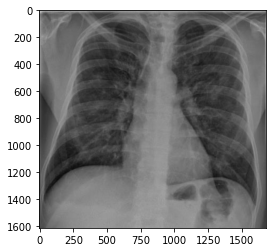

In [29]:
prediction('/content/drive/MyDrive/Datasets/covid, normal, neumonia/test/test/COVID19/10.jpg')

(1058, 1295, 3)
(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 1s 698ms/step
[[5.242200e-04 8.184664e-01 1.810093e-01]]
1
NORMAL


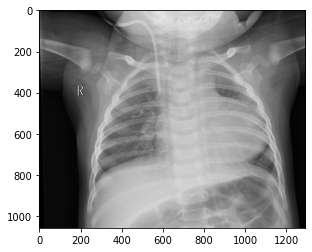

In [30]:
prediction('/content/drive/MyDrive/Datasets/covid, normal, neumonia/test/test/PNEUMONIA/1.jpg')

(1878, 1692, 3)
(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 1s 691ms/step
[[6.4074836e-04 9.7138017e-01 2.7979136e-02]]
1
NORMAL


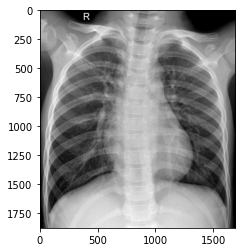

In [32]:
prediction('/content/drive/MyDrive/Datasets/covid, normal, neumonia/test/test/NORMAL/1.jpg')